In [1]:
from distributed import Executor, progress

In [2]:
e = Executor('dscheduler:8786')

In [3]:
e.restart()

<Executor: scheduler=dscheduler:8786 processes=3 cores=96>

In [4]:
import subprocess


def install_libs():
    libs = 'scikit-learn pandas matplotlib'.split()
    return subprocess.check_call('conda install -yq'.split() + libs)

install_libs()

0

In [5]:
e.run(install_libs)

{'10.112.0.5:51677': 0, '10.112.1.5:48459': 0, '10.112.2.3:53727': 0}

## Hyperparameter search for sklearn

In [6]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

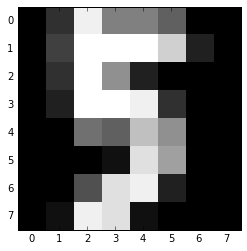

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(digits.data[35].reshape(8, 8),
           interpolation='nearest', cmap='gray');

### Sequential random parameter search

In [14]:
from sklearn.cross_validation import train_test_split


def load_cv_split(split_idx):
    data = load_digits()
    splitted = train_test_split(data.data, data.target,
                                test_size=0.20,
                                random_state=split_idx)
    return split_idx, splitted

In [15]:
from time import time
from sklearn.externals.joblib import hash


def evaluate_one(model_class, parameters, cv_split):
    split_idx, (X_train, X_val, y_train, y_val) = cv_split
    t0 = time()
    model = model_class(**parameters).fit(X_train, y_train)
    training_time = time() - t0

    train_score = model.score(X_train, y_train)
    validation_score = model.score(X_val, y_val)
    
    results = {
        'split_idx': split_idx,
        'training_time': training_time,
        'train_score': train_score,
        'val_score': validation_score,
        'parameters': parameters,
        'parameters_hash': hash(parameters),
    }
    return results

In [16]:
%%time
from sklearn.svm import SVC
from sklearn.grid_search import ParameterSampler
import numpy as np
import pandas as pd

param_grid = {
    'C': np.logspace(-10, 10, 1001),
    'gamma': np.logspace(-10, 10, 1001),
    'tol': np.logspace(-4, -1, 4),
}

param_space = ParameterSampler(param_grid, 3)

cv_splits = [load_cv_split(i) for i in range(2)]

results = [evaluate_one(SVC, params, split)
           for split in cv_splits
           for params in param_space]

CPU times: user 4.34 s, sys: 4 ms, total: 4.34 s
Wall time: 4.32 s


In [17]:
pd.DataFrame.from_dict(results).drop('parameters_hash', 1)

,parameters,split_idx,train_score,training_time,val_score
0,"{'tol': 0.0001, 'gamma': 13.1825673856, 'C': 0...",0,0.107168,0.415914,0.080556
1,"{'tol': 0.1, 'gamma': 2.29086765277, 'C': 1995...",0,1.000000,0.382794,0.080556
2,"{'tol': 0.0001, 'gamma': 6.3095734448e-09, 'C'...",0,0.107168,0.453139,0.080556
3,"{'tol': 0.0001, 'gamma': 1096478196.14, 'C': 6...",1,0.105776,0.385342,0.083333
4,"{'tol': 0.01, 'gamma': 4570881.89615, 'C': 4.7...",1,0.105776,0.390770,0.083333
5,"{'tol': 0.0001, 'gamma': 1.04712854805, 'C': 1...",1,1.000000,0.509900,0.083333


### Scaling out with dask + distributed

In [18]:
e = Executor('dscheduler:8786').restart()
n_cores = sum(e.ncores().values())
n_cores

96

In [19]:
from dask import delayed


param_space = ParameterSampler(param_grid, n_cores * 10)

cv_splits = [delayed(load_cv_split)(i) for i in range(3)]
        
delayed_evaluations = [delayed(evaluate_one)(SVC, params, split)
                       for split in cv_splits
                       for params in param_space]

In [20]:
delayed_evaluations[:5]

[Delayed('evaluate_one-eda62160-c097-45b1-94eb-99f5bdae64b9'),
 Delayed('evaluate_one-8c3582b4-9682-428d-a947-650a23eceb7a'),
 Delayed('evaluate_one-098b15f3-7952-4efc-be6b-c8eec9328abd'),
 Delayed('evaluate_one-f0e45dab-d6af-488e-97f5-4cd8b823e2bb'),
 Delayed('evaluate_one-24fe0893-259f-4e9c-a813-6bc79326ec7a')]

In [21]:
all_results = e.compute(delayed_evaluations)

In [22]:
progress(all_results)

In [24]:
results = e.gather([f for f in all_results if f.done()])
results = pd.DataFrame.from_dict(results)
results.describe()

,split_idx,train_score,training_time,val_score
count,2880.000000,2880.000000,2880.000000,2880.000000
mean,1.000000,0.545338,0.620006,0.247204
std,0.816638,0.443138,0.229472,0.342157
min,0.000000,0.105776,0.054810,0.077778
25%,0.000000,0.105776,0.599414,0.077778
50%,1.000000,0.160404,0.673221,0.080556
75%,2.000000,1.000000,0.750152,0.083333
max,2.000000,1.000000,1.145116,0.994444


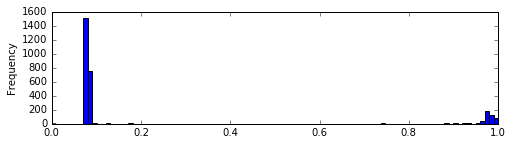

In [25]:
plt.figure(figsize=(8, 2))
bins = np.linspace(0, 1, 100)
results['val_score'].plot(kind='hist', bins=bins);

### Aggregation of scores across CV folds

In [26]:
mean_evaluations = results.groupby('parameters_hash').agg({
    'train_score': np.mean,
    'val_score': np.mean,
    'training_time': np.mean,
}).reset_index()

all_parameters = pd.DataFrame.from_dict(list(results['parameters']))
all_parameters['parameters_hash'] = results['parameters_hash']

evaluations = (
    mean_evaluations
    .merge(all_parameters)
    .drop(['parameters_hash'], axis=1)
)
top10 = evaluations.sort_values(
    by='val_score', ascending=False).head(10)
top10

,training_time,val_score,train_score,C,gamma,tol
56,0.218744,0.994444,0.998608,6.606934e-01,9.549926e-04,0.0010
1065,0.347353,0.994444,1.000000,3.467369e+02,1.737801e-03,0.0001
1103,0.297653,0.994444,1.000000,1.905461e+00,1.659587e-03,0.0010
125,0.342021,0.994444,1.000000,6.606934e+04,1.737801e-03,0.0001
1860,0.337327,0.994444,1.000000,3.311311e+06,1.659587e-03,0.0010
2285,0.119202,0.991667,1.000000,8.709636e+07,2.630268e-06,0.0010
900,0.076256,0.991667,1.000000,1.047129e+05,1.380384e-07,0.0100
53,0.136052,0.991667,1.000000,6.918310e+01,5.248075e-04,0.0010
1560,0.102807,0.991667,1.000000,2.398833e+03,8.709636e-06,0.0010
2291,0.113883,0.991667,0.988866,6.606934e+01,7.943282e-06,0.0001


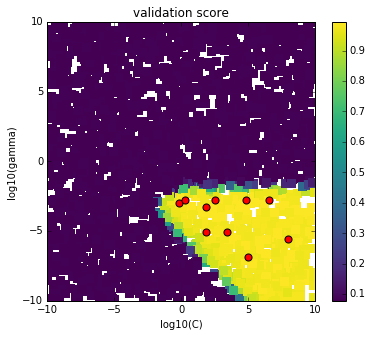

In [27]:
import matplotlib.pyplot as plt

def plot_param_map(df, target, title):
    plt.xlabel('log10(C)')
    plt.ylabel('log10(gamma)')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(np.log10(df['C']), np.log10(df['gamma']),
                c=target,
                marker='s', edgecolors='none',
                s=80, alpha=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['val_score'],
               'validation score')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

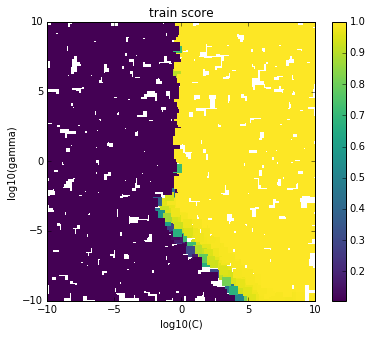

In [28]:
plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['train_score'], 'train score')

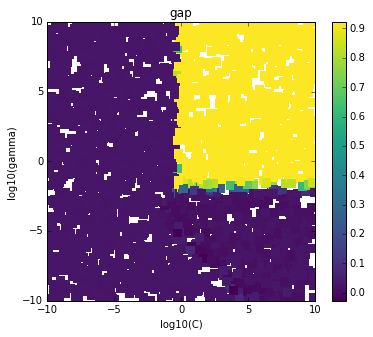

In [29]:
plt.figure(figsize=(6, 5))
gap = evaluations['train_score'] - evaluations['val_score']
plot_param_map(evaluations, gap, 'gap')

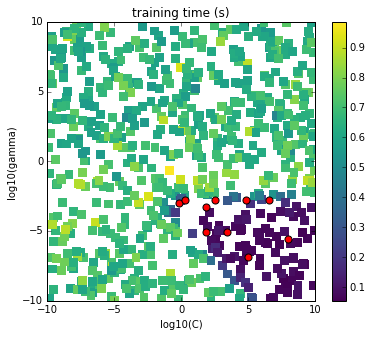

In [30]:
plt.figure(figsize=(6, 5))
high_tol = evaluations[evaluations['tol'] == 0.1]

plot_param_map(high_tol, high_tol['training_time'], 'training time (s)')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

## Scaling down

### Single local python process, multiple threads

In [31]:
import dask
%time _ = dask.compute(*delayed_evaluations[:10])

CPU times: user 6.3 s, sys: 32 ms, total: 6.33 s
Wall time: 928 ms


### Single local python process, no parallelism

In [32]:
from dask.async import get_sync

%time _ = dask.compute(*delayed_evaluations[:10], get=get_sync)

CPU times: user 6.33 s, sys: 4 ms, total: 6.33 s
Wall time: 6.31 s


In [33]:
%prun _ = dask.compute(*delayed_evaluations[:10], get=get_sync)